In [1]:
from dotenv import load_dotenv
from langchain_openai import AzureChatOpenAI, ChatOpenAI
import os
from langchain.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from sentence_transformers import SentenceTransformer # type: ignore
from langchain_openai import OpenAIEmbeddings
from langchain.vectorstores import FAISS
# from langchain.globals import set_llm_cache
from langchain_community.cache import InMemoryCache
from langchain_core.prompts import PromptTemplate
from langchain.chains import RetrievalQA
import tqdm
load_dotenv()

/Users/siddartha/miniforge3/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


True

In [86]:
# llm = AzureChatOpenAI(openai_api_version=os.environ.get("AZURE_OPENAI_VERSION", "2023-07-01-preview"),
#     azure_deployment=os.environ.get("AZURE_OPENAI_DEPLOYMENT", "gpt4chat"),
#     azure_endpoint=os.environ.get("AZURE_OPENAI_ENDPOINT", "https://gpt-4-trails.openai.azure.com/"),
#     api_key=os.environ.get("AZURE_OPENAI_KEY"))

In [2]:
llm = ChatOpenAI(
    model = "gpt-3.5-turbo",
    temperature = 0.4,
    max_tokens = 400,
)
embeddings = OpenAIEmbeddings(model="text-embedding-ada-002")

In [3]:
file_path = "policy_data.pdf"
loader = PyPDFLoader(file_path)
pages = loader.load()

In [4]:
len(pages)

44

In [5]:
splitter = RecursiveCharacterTextSplitter(
    chunk_size=700,
    chunk_overlap=50,
    length_function=len,
)

In [6]:
pages_text = [pages.page_content for pages in pages]
# the type of pages is documents but we need to convert them into list of strings for splitting the text.

In [7]:
documents = splitter.create_documents(pages_text)
# splitting the text into chunks of 250 characters and 50 characters overlap.

In [8]:
print(documents[2])

page_content='About the policy\nThe policy is made up of:\n >This booklet.\n >Your car insurance details.\n >Your certificate (or certificates)  \nof motor insurance.\nIf the policy includes Green Flag breakdown cover:\n >Your breakdown cover and your car \ninsurance are part of the same policy.\n >The policy also includes the Green Flag \npolicy booklet we’ve given you.\nIf you have a policy that includes DriveSure:\n >The policy also includes the DriveSure terms \nand conditions we’ve given you.\nPlease read all these documents carefully  and keep them safe in case you need them.Words in bold type\nSome of the words and phrases we use in \nthis booklet have a specific meaning – for example, your car or modifications.'


In [10]:
def get_vectorstore(text_chunks):
    # Check if the FAISS index file already exists
    if os.path.exists("faiss_index"):
        embeddings = OpenAIEmbeddings()
        # Load the existing FAISS index
        vectorstore = FAISS.load_local("faiss_index", embeddings, allow_dangerous_deserialization=True) # used this because it is my local desktop mode
        print("Loaded existing FAISS index.")
    else:
        # Create a new FAISS index
        embeddings = OpenAIEmbeddings()
        vectorstore = FAISS.from_documents(documents=text_chunks, embedding=embeddings)
        # Save the new FAISS index locally
        vectorstore.save_local("faiss_index")
        print("Created and saved new FAISS index.")
    return vectorstore

In [11]:
vectorstore = get_vectorstore(documents).as_retriever()

Loaded existing FAISS index.


In [12]:
template = """Use the context below to answer the question.
Keep the answer concise and to the point.
If you are unsure about the answer, just say i do not know the answer to the question do not create your own answer and make sure the answer is concise and to the point.
Summarize the information such that main points are covered and if you think that there needs to be some more information added to the answer then you can add that information as well.
{context}

Question: {question}

Helpful Answer:"""
prompt = PromptTemplate.from_template(template)

In [13]:
chain_type_kwargs = {"prompt": prompt}
chain = RetrievalQA.from_chain_type(
    llm = llm,
    chain_type="stuff",
    retriever=vectorstore,
    chain_type_kwargs=chain_type_kwargs,
)

In [14]:
import pandas as pd
df = pd.read_excel('/Users/siddartha/Desktop/github/Athina_AI_project/dataset_testing/dataset_for_testing.xlsx')

In [15]:
questions = df["question"].to_list()
ground_truth = df["ground_truth"].to_list()

In [16]:
from datasets import Dataset
data = {"question": [], "answer": [], "contexts": [], "ground_truth": ground_truth}

for query in questions:
    data["question"].append(query)
    data["answer"].append(chain.invoke(query))
    data["contexts"].append([doc.page_content for doc in vectorstore.get_relevant_documents(query, top_k=5)])

dataset = Dataset.from_dict(data)

/Users/siddartha/miniforge3/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


In [17]:
df = pd.DataFrame(dataset)

In [18]:
df['answer'] = df['answer'].apply(lambda x: x['result'])

In [19]:
df.to_csv('/Users/siddartha/Desktop/github/Athina_AI_project/dataset_testing/final_dataset_testing.csv', index=False)

In [20]:
dataset = Dataset.from_pandas(df)

In [29]:
import ragas
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
)
run_config = ragas.RunConfig(timeout=60, max_retries=10, max_wait=100, max_workers=1)

result = evaluate(
    dataset = dataset,
    llm = llm,
    embeddings=embeddings,
    run_config=run_config,
    metrics=[
        faithfulness,
        answer_relevancy,
    ],
)

Evaluating:   0%|          | 0/92 [00:00<?, ?it/s]

Failed to parse output. Returning None.


In [30]:
result

{'faithfulness': 0.8067, 'answer_relevancy': 0.9225}

/Users/siddartha/miniforge3/lib/python3.10/site-packages/datasets/table.py:1381: FutureWarning: promote has been superseded by promote_options='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/Users/siddartha/miniforge3/lib/python3.10/site-packages/datasets/table.py:1407: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)
/Users/siddartha/miniforge3/lib/python3.10/site-packages/matplotlib/_api/__init__.py:124: RuntimeWarning: coroutine 'Executor.wrap_callable_with_index.<locals>.wrapped_callable_async' was never awaited
  for key, val in kwargs.items():
Exception ignored in: <coroutine object as_completed.<locals>.sema_coro at 0x1754d95b0>
Traceback (most recent call last):
  File "/Users/siddartha/miniforge3/lib/python3.10/site-packages/ragas/executor.py", line 36, in sema_coro
    async with semaphore:
  File "/Users/siddartha/miniforge3/lib/python3.10/asyncio/locks.py", lin

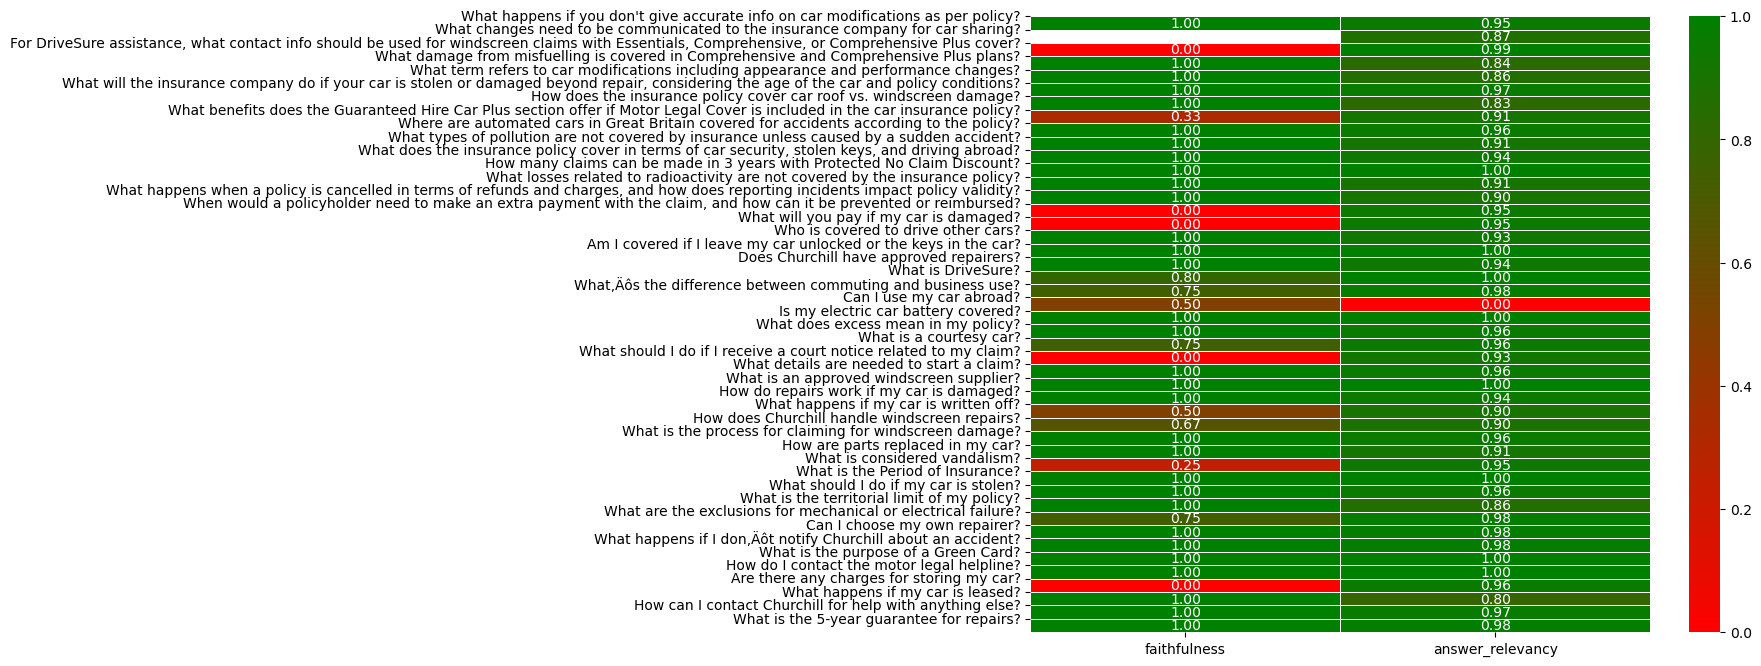

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

df = result.to_pandas()

heatmap_data = df[['faithfulness', 'answer_relevancy']]

cmap = LinearSegmentedColormap.from_list('green_red', ['red', 'green'])

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", linewidths=.5, cmap=cmap)

plt.yticks(ticks=range(len(df['question'])), labels=df['question'], rotation=0)

plt.show()